In [319]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [320]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [321]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [322]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [323]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [324]:
def get_discount_matrix(size):
    a = np.arange(size)
    a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    np.fill_diagonal(a, 0)

    return a

In [325]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [326]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


In [327]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)
# np.fill_diagonal(NW, 0)
print('W', W.shape, W.max(), W.min(), np.median(W))

iter_cnt = 100*2

eps0 = 0.01
eps = eps0

for img in images[:1]:
    I = np.copy(img)
    print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

    # print(img)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    for iter_idx in range(iter_cnt):
        # eps = (iter_cnt - iter_idx) * eps0

        # infer
        DO = np.exp((I - W)**2 * -20.0)
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        dO /= np.max(dO)
        O += dO

        # O[np.where(O < 0)] = 0
        # O /= np.max(O)
        
        # O = O ** 2
        print(f'{np.max(O)=}')

        # inhibition
        NDO = np.exp((O - NW)**2 * -20.0)
        np.fill_diagonal(NDO, 0)
        # NDO = NDO ** 2
        dNO = np.sum(NDO, axis=1)
        dNO /= np.max(dNO)
        O -= dNO
        # O -= np.sum(NDO, axis=1) * 1.0

        O[np.where(O < 0)] = 0
        # O /= np.max(O)
        print(f'{np.max(O)=} {np.max(NDO)=}')

        threshold = np.mean(O)
        # threshold = np.mean(O[np.where(O > 0)])

        # inh train
        dNW = (O - NW) * eps * dNO
        dNW[np.where(O > threshold)] = 0

        # inh update
        NW += dNW

        # train
        dW = (I - W) * eps * dO
        dW[np.where(O <= threshold)] = 0

        # update
        W += dW

        # stats
        SP.append(np.sum(O))
        MP.append(np.mean(O))
        CP.append(np.sum(O > 0))
        DP.append(np.sum(np.abs(I - W) + np.abs(O - NW)))

        # recur
        O /= np.max(O)

        I = np.copy(O)

        OST.append(np.copy(O))

print('W', W.shape, W.max(), W.min(), np.median(W))

W (784, 784) 0.999999886418506 3.177014604727191e-07 0.4987407122937512
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
np.max(O)=1.0
np.max(O)=0.16387043172639948 np.max(NDO)=0.9999999999988459
np.max(O)=1.9351145543273325
np.max(O)=1.1381971293264879 np.max(NDO)=0.999999999999456
np.max(O)=1.9308107066026547
np.max(O)=1.128826481963117 np.max(NDO)=0.9999999999999365
np.max(O)=1.9308410157432243
np.max(O)=1.1204992387119743 np.max(NDO)=0.9999999992605879
np.max(O)=1.935190689103089
np.max(O)=1.1267743927156757 np.max(NDO)=0.9999999999233342
np.max(O)=1.9412575808125023
np.max(O)=1.1140052910821667 np.max(NDO)=0.9999999999902266
np.max(O)=1.9467482168556391
np.max(O)=1.1020350317347587 np.max(NDO)=0.9999999999830709
np.max(O)=1.9512187277846746
np.max(O)=1.0905183312749693 np.max(NDO)=0.9999999999958546
np.max(O)=1.9557807927465722
np.max(O)=1.0885926758796152 np.max(NDO)=0.9999999999996658
np.max(O)=1.9631955249020356
np.max(O)=1.113365485461556 np.max(NDO)=0.99999999999195
np

CP[-1]=13


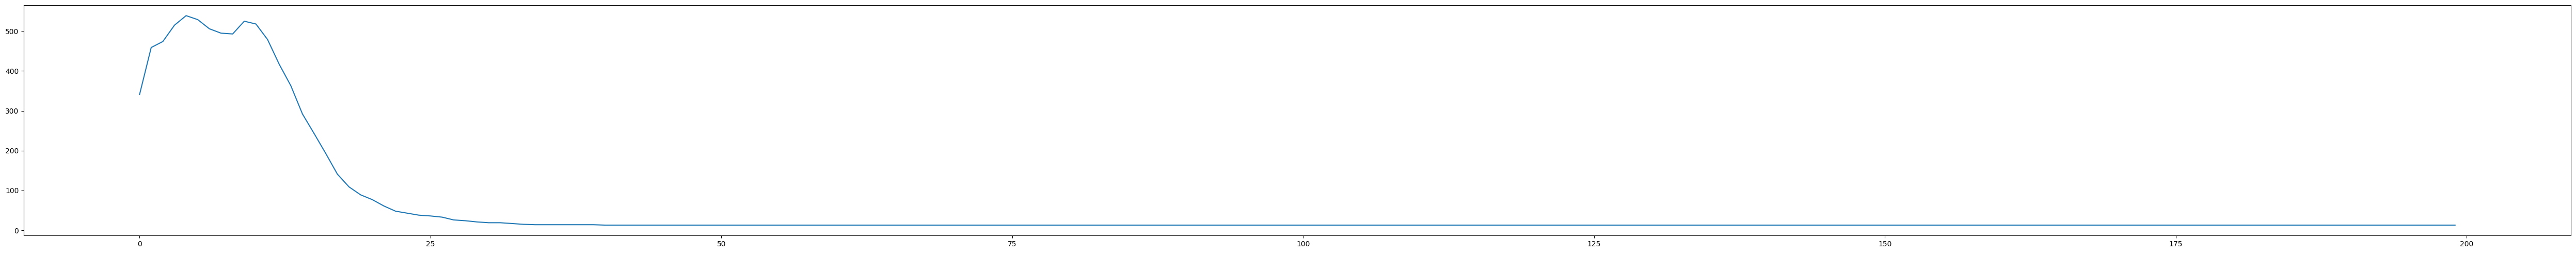

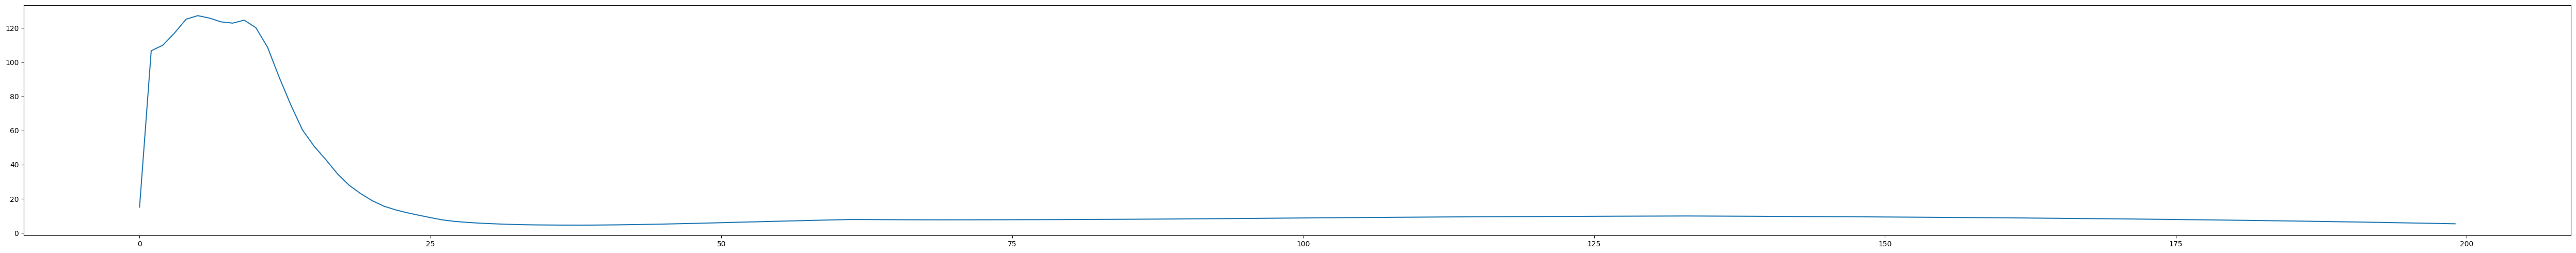

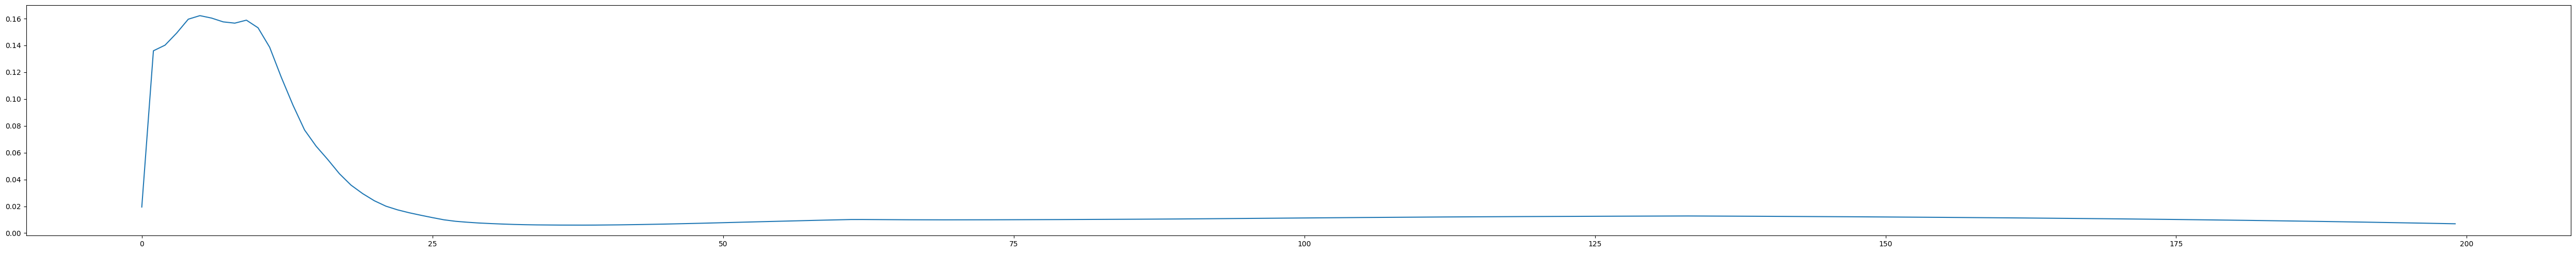

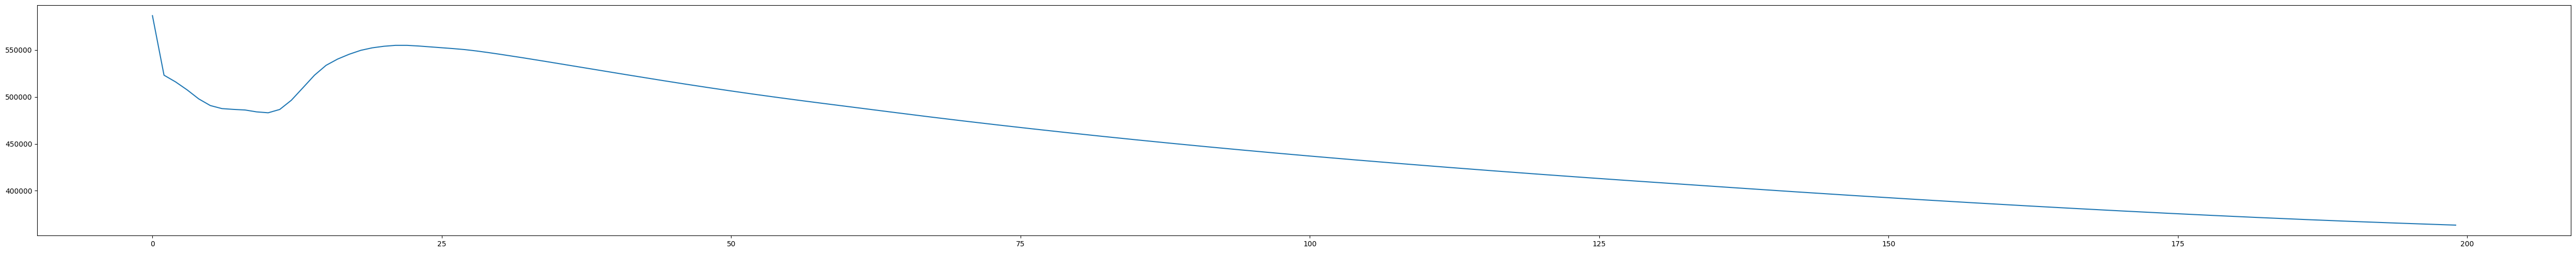

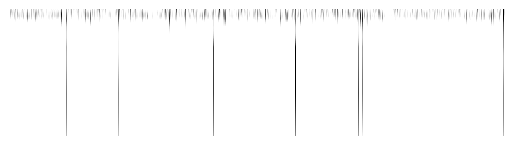

In [328]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

In [329]:
CP[-20:-1]

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]

i_T[-1]=0.05625174425884018


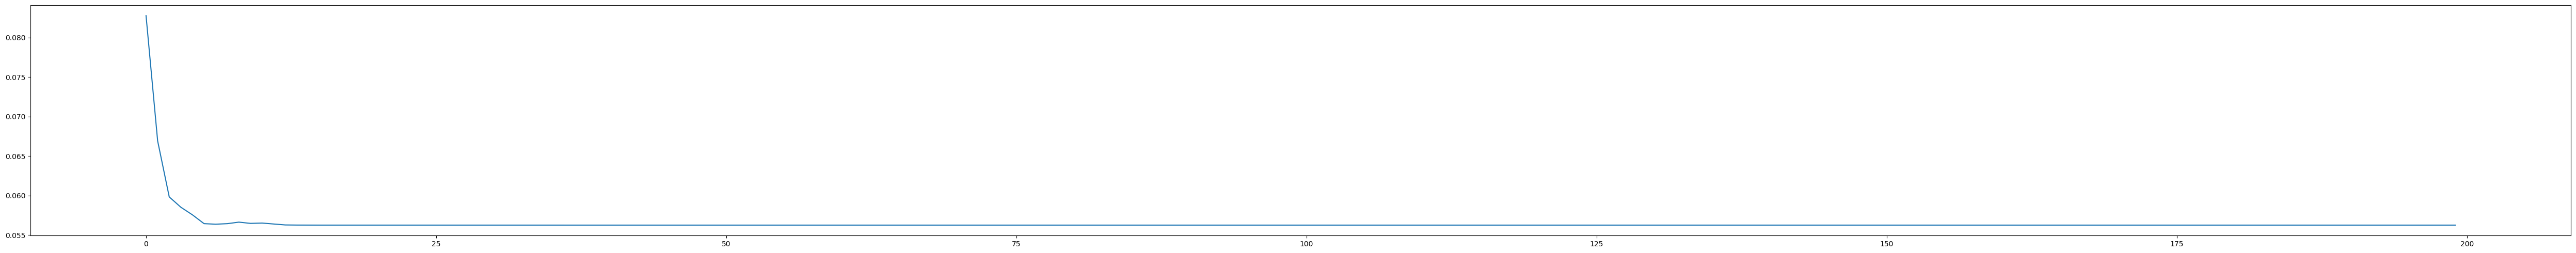

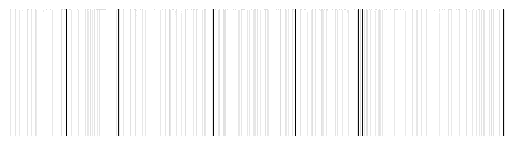

In [330]:
i_T, i_OST = infer(input=images[1], W=W, iter_cnt=iter_cnt)

print(f'{i_T[-1]=}')
simple_plot(T=i_T)

show_image(image=i_OST, cmap='Greys')

[[ 0 98 97 ...  2  1  0]
 [98  0 98 ...  3  2  1]
 [97 98  0 ...  4  3  2]
 ...
 [ 2  3  4 ...  0 98 97]
 [ 1  2  3 ... 98  0 98]
 [ 0  1  2 ... 97 98  0]]


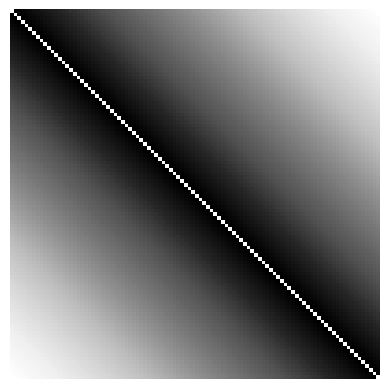

In [331]:
a = get_discount_matrix(100)
2 * a
print(a)
show_image(a, cmap='Greys')